# Caprini Lellouch Neubert (CLN) parametrization

The CLN parametrization is used to describe the semileptonic decay $B^0 \longrightarrow D^{*-}\ell^+ \nu_{\ell}$ $(\ell = e, \mu)$ and a one-dimensional projection of the differential decay rate into the variables $w$, $cos(\theta_{l})$, $cos(\theta_{\nu})$ and $\chi$ is calculated. Each distribution is divided into 10 bins. For each bin, the number of expected events is calculated using the detector response matrix and the efficiency.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.integrate import quad

#import data
def import_matrix_mn(name, m=40, n=40, delimiter="=", value_position=3):
    """
    Import data from a file into a matrix of shape (m, n).

    Parameters:
    - name (str): The name of the file to read from.
    - m (int): The number of rows for the matrix. Default is 40.
    - n (int): The number of columns for the matrix. Default is 40.
    - delimiter (str): The character used to split each line in the file. Default is "=".
    - value_position (int): The position of the desired value after splitting each line. Default is 3.

    Returns:
    - np.ndarray: A matrix of shape (m, n) populated with data from the file.
    - None: If there's an error during processing.
    """
    a = np.zeros(shape=(m,n))

    try:
        with open(name, 'r') as fobj:           
            # Count the total number of lines in the file
            line_count = sum(1 for _ in fobj)
            
            # Reset the file pointer to the beginning of the file
            fobj.seek(0)
            
            # Skip the first two lines
            fobj.readline()
            fobj.readline()
            
            # Check if the file has the expected number of lines for the matrix
            if line_count != m * n + 2:
                print(f"Error: Expected {m * n + 2} lines, but found {line_count}.")
                return None
            
            # Iterate over each line to fill the matrix
            for i, line in enumerate(fobj):
                # Split the line based on the provided delimiter
                x = line.split(delimiter)
                
                # Check if the line has enough elements after splitting
                if len(x) < 4:
                    print(f"Error: Line {i + 3} does not have the expected format.")
                    return None
                
                # Fill the matrix with the desired value
                a[i // n, i % n] = float(x[value_position]) 
                
    except Exception as inst:
        # Print any other errors that might occur
        print(f"Error: {inst}")
        return None
    
    return a

def import_data_m(name, m=40):
    """
    Import data from a file into a list of length m.

    Parameters:
    - name (str): The name of the file to read from.
    - m (int): The length of the list. Default is 40.
    - delimiter (str): The character used to split each line in the file. Default is "=".
    - value_position (int): The position of the desired value after splitting each line. Default is 2.

    Returns:
    - np.ndarray: A list of length m populated with data from the file.
    - None: If there's an error during processing.
    """
    a = np.zeros(shape=(m))

    try:
        with open(name, 'r') as fobj:
            # Count the total number of lines in the file
            line_count = sum(1 for _ in fobj)
            
            # Reset the file pointer to the beginning of the file
            fobj.seek(0)
            
            # Skip the first two lines
            fobj.readline()
            fobj.readline()
            
            # Check if the file has the expected number of lines for the list
            if line_count != m + 2:
                print(f"Error: Expected {m + 2} lines, but found {len(line_count)}.")
                return None

            # Iterate over each line to fill the list
            for i, line in enumerate(fobj):
                # Split the line based on the provided delimiter
                x=line.split("=")
                
                # Check if the line has enough elements after splitting
                if len(x) < 3:
                    print(f"Error: Line {i + 3} does not have the expected format.")
                    return None
                
                # Fill the list with the desired value
                a[i]=float(x[2])
                
    except Exception as inst:
        # Print any other errors that might occur
        print(f"Error: {inst}")
        return None
 
    return a

# Import detector response matrix
#Res_e=import_matrix_mn("Response0.txt") 

# Import efficiency
#epsilon_e = import_data_m("efficiency0.txt") 

Res_e=np.identity(40)
epsilon_e=np.ones((40))*0.1

In [2]:
#CLN Parametrization

# Constants
W_STEP = 0.05
W_START = 1.0
W_END = 1.5
COS_THETA_STEP = 0.2
COS_THETA_START = -1.0
COS_THETA_END = 1.0
CHI_STEP = 0.2 * np.pi
CHI_START = - np.pi
CHI_END = np.pi
NUM_BINS = 40
NUM_TERMS = 4
GF = 1.16637 * 10**(-5)
mDs = 2.01
mB = 5.279
#ETA_EW = 1.0066
ETA_EW = 1.0
NBB = 771.581 * 10**6 
B1 = 0.677            #B(D*+ --> D0 PI+)
B2 = 0.0393           #B(D0 --> K- PI+)
TAU_B0 = 1519 * 10**(-15)
F00 = 0.486
NB0 = 2.0 * F00 * NBB
S_PER_GEV_OVER_HBAR = 1.0 / (6.58212 * 10**(-25)) # s/(GeV/hbar)

def z(w):
    """Calculate z based on w."""
    return ((w+1.0)**0.5 - 2.0**0.5) / ((w + 1.0)**0.5 + 2.0**0.5)

def hA1(w,rho2):
    """Calculate hA1 based on w and rho2."""
    #hA1_1 = 0.906
    hA1_1 = 1.0
    return hA1_1*(1.0 - 8.0 * rho2 * z(w) + (53.0 * rho2 - 15.0) * z(w)**2.0 - (231.0 * rho2 - 91.0) * z(w)**3.0)

def R1(w,R1_1):
    """Calculate R1 based on w and R1_1."""
    return R1_1 - 0.12 * (w - 1.0) + 0.05 * (w-1.0)**2.0

def R2(w,R2_1):
    """Calculate R2 based on w and R2_1."""
    return R2_1 + 0.11 * (w - 1.0) - 0.06 * (w - 1.0)**2.0

def H0(w,para):
    """Calculate H0 based on w and para."""
    rho2, R1_1, R2_1, _ = para
    r = mDs / mB
    Rs = 2.0 * np.sqrt(mB * mDs) / (mB + mDs)
    H0 = mB * Rs * (1.0 - r**2.0) * (w + 1.0) / (2.0 * np.sqrt(1.0 - 2.0 * r * w + r**2)) * hA1(w,rho2)
    H0 = H0 * (1.0 + (1.0 - R2(w, R2_1)) * (w - 1.0) / (1 - r))
    return H0

def Hp(w,para):
    """Calculate Hp based on w and para."""
    rho2, R1_1, R2_1, _ = para
    r = mDs / mB
    Rs = 2.0 * np.sqrt(mB * mDs) / (mB + mDs)
    Hp = mB * Rs * (1.0 - r**2.0) * (w + 1.0) / (2.0 * np.sqrt(1.0 - 2.0 * r * w + r**2.0)) * hA1(w,rho2)
    Hp = Hp * np.sqrt(1.0 - 2.0 * r * w + r**2.0)/(1.0 - r) * (1.0 - R1(w,R1_1) * np.sqrt((w - 1.0)/(w + 1.0)))
    return Hp

def Hm(w,para):
    """Calculate Hm based on w and para."""
    rho2, R1_1, R2_1, _ = para
    r = mDs / mB
    Rs = 2 * np.sqrt(mB * mDs) / (mB + mDs)
    Hm = mB * Rs * (1.0 - r**2.0) * (w + 1.0) / (2.0 * np.sqrt(1.0 - 2.0 * r * w + r**2)) * hA1(w,rho2)
    Hm = Hm * np.sqrt(1.0 - 2.0 * r * w + r**2.0)/(1.0 - r) * (1.0 + R1(w,R1_1) * np.sqrt((w - 1.0)/(w + 1.0)))
    return Hm

def Il1(a,b):
    """Integral (1-cos(theta_l))^2"""
    return b - b**2 + b**3 / 3.0 - (a - a**2 + a**3 / 3.)

def Il2(a,b):
    """Integral (1+cos(theta_l))^2"""
    return b + b**2 + b**3 / 3.0 - (a + a**2 + a**3 / 3.0)

def Il3(a,b):
    """Integral 1-cos(theta_l)^2"""
    return b - b**3 / 3.0 - (a - a**3 / 3.0)

def Il4(a,b):
    """Integral 1-cos(theta_l)^2"""
    return b - b**3 / 3.0 - (a - a**3 / 3.0)

def In1(a,b):
    """Integral 1-cos(theta_nu)^2"""
    return b - b**3 / 3.0 - (a - a**3 / 3.0)

def In2(a,b):
    """Integral 1-cos(theta_nu)^2"""
    return b - b**3 / 3.0 - (a - a**3 / 3.0)

def In3(a,b):
    """Integral cos(theta_nu)^2"""
    return b**3 / 3.0 - (a**3 / 3.0)

def In4(a,b):
    """Integral 1-cos(theta_nu)^2"""
    return b - b**3 / 3.0 - (a - a**3 / 3.0)

def Ic1(a,b):
    """Integral 1"""
    return b - a

def Ic2(a,b):
    """Integral 1"""
    return b - a

def Ic3(a,b):
    """Integral 1"""
    return b - a

def Ic4(a,b):
    """Integral cos(2*chi)"""
    return 0.5 * np.sin(2.0 * b) - 0.5 * np.sin(2.0 * a)

def w1(w, para):
    """sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hp^2"""
    r = mDs / mB
    return np.sqrt(w**2 - 1.0) * (1.0 - 2.0 * w * r + r**2) * Hp(w,para)**2

def Iw1(a,b,para, tol=1e-6):
    """Integral sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hp^2"""
    I, error = quad(w1, a, b, args=(para))
    if error > tol:
        raise ValueError(f"Integration error {error} exceeds tolerance {tol}!")
    return I

def w2(w, para):
    """sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hm^2"""
    r = mDs / mB
    return np.sqrt(w**2 - 1.0) * (1.0 - 2.0 * w * r + r**2)*Hm(w,para)**2

def Iw2(a,b,para, tol=1e-6):
    """Integral sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hm^2"""
    I, error = quad(w2, a, b, args=(para))
    if error > tol:
        raise ValueError(f"Integration error {error} exceeds tolerance {tol}!")
    return I

def w3(w, para):
    """4*sqrt(w^2-1)*(1.-2.*w*r+r**2)*H0^2"""
    r = mDs / mB
    return 4.0 * np.sqrt(w**2 - 1.0) * (1.0 - 2.0 * w * r + r**2) * H0(w,para)**2

def Iw3(a,b,para, tol=1e-6):
    """Integral 4*sqrt(w^2-1)*(1.-2.*w*r+r**2)*H0^2"""
    I, error = quad(w3, a, b, args=(para))
    if error > tol:
        raise ValueError(f"Integration error {error} exceeds tolerance {tol}!")
    return I

def w4(w, para):
    """-2*sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hp*Hm"""
    r = mDs / mB
    return -2.0 * np.sqrt(w**2 - 1.0) * (1.0 - 2.0 * w * r + r**2) * Hp(w,para) * Hm(w,para)

def Iw4(a,b,para, tol=1e-6):
    """Integral -2*sqrt(w^2-1)*(1.-2.*w*r+r**2)*Hp*Hm"""
    I, error = quad(w4, a, b, args=(para))
    if error > tol:
        raise ValueError(f"Integration error {error} exceeds tolerance {tol}!")
    return I

def integral_list_distributions():
    """
    Calculate the integrals for the distributions of cos(theta_l), cos(theta_nu), and chi.
    
    Returns:
        tuple: A tuple containing three lists of integrals for cos(theta_l), cos(theta_nu), and chi.
    """
    #Integral from cos(theta_l)=-1 to cos(theta_l)=1
    Il = [Il1(COS_THETA_START, COS_THETA_END), Il2(COS_THETA_START, COS_THETA_END), 
          Il3(COS_THETA_START, COS_THETA_END), Il4(COS_THETA_START, COS_THETA_END)]

    #Integral from cos(theta_nu)=-1 to cos(theta_nu)=1
    In = [In1(COS_THETA_START, COS_THETA_END), In2(COS_THETA_START, COS_THETA_END), 
          In3(COS_THETA_START, COS_THETA_END), In4(COS_THETA_START, COS_THETA_END)]

    #Integral from chi=-Pi to chi=Pi
    Ic = [Ic1(CHI_START, CHI_END), Ic2(CHI_START, CHI_END), 
          Ic3(CHI_START, CHI_END), Ic4(CHI_START, CHI_END)]
    
    return (Il, In, Ic)


def integral_list_bins():
    """
    Calculate the integrals for the bins of cos(theta_l), cos(theta_nu), and chi.
    
    Returns:
        ndarray: A 2D numpy array containing the integrals for the bins separated into 4 terms.
    """
    I_40 = np.zeros(shape=(NUM_TERMS, NUM_BINS))
    for m in range(0, 10):
        #Integral from cos(theta_l)=-1 to -0.8, -0.8 to -0.6, -0.6 to -0.4, ...
        I_40[0, m+10] = Il1(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 1
        I_40[1, m+10] = Il2(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 2
        I_40[2, m+10] = Il3(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 3
        I_40[3, m+10] = Il4(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 4

        #Integral from cos(theta_n)=-1 to -0.8, -0.8 to -0.6, -0.6 to -0.4, ...
        I_40[0, m+20] = In1(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 1
        I_40[1, m+20] = In2(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 2
        I_40[2, m+20] = In3(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 3
        I_40[3, m+20] = In4(m * COS_THETA_STEP + COS_THETA_START, m * COS_THETA_STEP + COS_THETA_START + COS_THETA_STEP) #term 4

        #Integral from chi=-Pi to -0.8*Pi, -0.8*Pi to -0.6*Pi, -0.6*Pi to -0.4*Pi, ...
        I_40[0, m+30] = Ic1(m * CHI_STEP + CHI_START, m * CHI_STEP + CHI_START + CHI_STEP) #term 1
        I_40[1, m+30] = Ic2(m * CHI_STEP + CHI_START, m * CHI_STEP + CHI_START + CHI_STEP) #term 2
        I_40[2, m+30] = Ic3(m * CHI_STEP + CHI_START, m * CHI_STEP + CHI_START + CHI_STEP) #term 3
        I_40[3, m+30] = Ic4(m * CHI_STEP + CHI_START, m * CHI_STEP + CHI_START + CHI_STEP) #term 4
    return I_40

    
#calculate number of expected events
def N_exp_e(para, I_dist, I_40):  
    """
    Calculate the number of expected events based on the given parameters and integrals.
    
    Args:
        para (list): List of parameters.
        I_dist (tuple): Tuple containing lists of integrals for distributions.
        I_40 (ndarray): 2D numpy array containing the integrals for the bins.
        
    Returns:
        ndarray: A numpy array containing the number of expected events.
    """
    N_exp = np.zeros(shape=(NUM_BINS))
    
    rho2, R1_1, R2_1, Vcb_etaEW_F1 = para
    Il, In, Ic = I_dist
        
    r = mDs/mB
    
    #Integral from w=1.0 to 1.05, 1.05 to 1.10, 1.10 to 1.15, ...
    
    for m in range(0, 10):
        I_40[0, m] = Iw1(m * W_STEP + W_START, m * W_STEP + W_START + W_STEP, para) #term 1
        I_40[1, m] = Iw2(m * W_STEP + W_START, m * W_STEP + W_START + W_STEP, para) #term 2
        I_40[2, m] = Iw3(m * W_STEP + W_START, m * W_STEP + W_START + W_STEP, para) #term 3
        I_40[3, m] = Iw4(m * W_STEP + W_START, m * W_STEP + W_START + W_STEP, para) #term 4
    
    #Integral from w=1.0 to w=1.5
    Iw = [sum(I_40[0,0:10]), sum(I_40[1,0:10]), sum(I_40[2,0:10]), sum(I_40[3,0:10])]
    
    #calculate number of expected events bin 1..10
    for n in range(0,10):
        for m in range(0, NUM_BINS):
            Int = 0.
            for o in range(0, NUM_TERMS): #sum over term 1 to 4
                Int = Int + I_40[o,m] * Il[o] * In[o] * Ic[o]
            N_exp[n] = N_exp[n] + Res_e[n,m] * epsilon_e[m] * Int
    
    #calculate number of expected events bin 11..20
    for n in range(10,20):
        for m in range(0, NUM_BINS):
            Int = 0.
            for o in range(0, NUM_TERMS): #sum over term 1 to 4
                Int = Int + Iw[o] * I_40[o,m] * In[o] * Ic[o]
            N_exp[n] = N_exp[n] + Res_e[n,(m)] * epsilon_e[(m)] * Int
    
    #calculate number of expected events bin 21..30
    for n in range(20,30):
        for m in range(0, NUM_BINS):
            Int = 0.
            for o in range(0, NUM_TERMS): #sum over term 1 to 4
                Int = Int + Iw[o] * Il[o] * I_40[o,m] * Ic[o]
            N_exp[n] = N_exp[n] + Res_e[n,(m)] * epsilon_e[(m)] * Int
  
    #calculate number of expected events bin 31..40
    for n in range(30,40):
        for m in range(0, NUM_BINS):
            Int = 0.
            for o in range(0, NUM_TERMS): #sum over term 1 to 4
                Int = Int + Iw[o] * Il[o] * In[o] * I_40[o,m]
            N_exp[n] = N_exp[n] + Res_e[n,(m)] * epsilon_e[(m)] * Int  

    N_exp = N_exp * NB0 * B1 * B2 * TAU_B0 * S_PER_GEV_OVER_HBAR
    N_exp = N_exp * ETA_EW**2 * 3.0 * mB * mDs**2 /(4.0 * (4.0 * np.pi)**4.0) * GF**2 * Vcb_etaEW_F1**2
    
    return N_exp

def test_N_exp_e():
    """
    Test the N_exp_e function to ensure its correctness.
    """
    I_dist = integral_list_distributions()
    I_40 = integral_list_bins()
    parameter = [1.166, 1.184, 0.848, 0.03648]
    result = N_exp_e(parameter, I_dist, I_40)
    
    expected = [5823.92618833,  9746.16423311, 11410.51765749, 12116.72547764,
                12214.35163109, 11878.02484298, 11215.05906842, 10299.57961772,
                9187.05151433,  7921.66450461,  4182.00031541,  6488.77449034,
                8430.45052951, 10007.02843294, 11218.50820061, 12064.88983254,
                12546.17332871, 12662.35868913, 12413.44591381, 11799.43500273,
                14562.48410258, 11641.69901657,  9451.11020207,  7990.71765907,
                7260.52138757,  7260.52138757,  7990.71765907,  9451.11020207,
                11641.69901657, 14562.48410258,  8765.58745483, 10722.06302021,
                11931.23141777, 10722.06302021,  8765.58745483,  8765.58745483,
                10722.06302021, 11931.23141777, 10722.06302021,  8765.58745483]
    assert np.allclose(result, expected, atol=0.001), f"Expected {expected}, but got {result}"
test_N_exp_e()

parameter: [1.166, 1.184, 0.848, 0.03648]


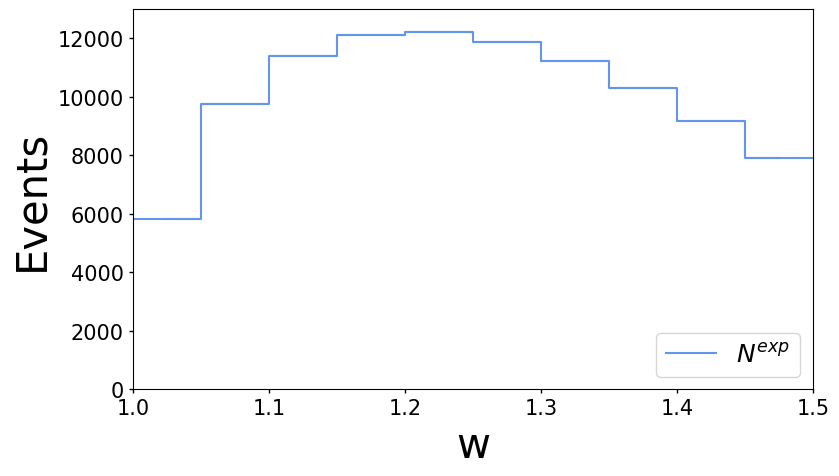

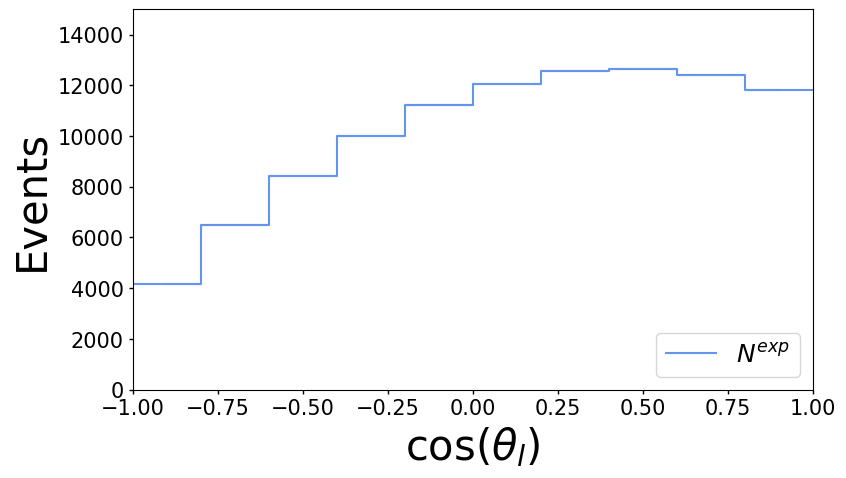

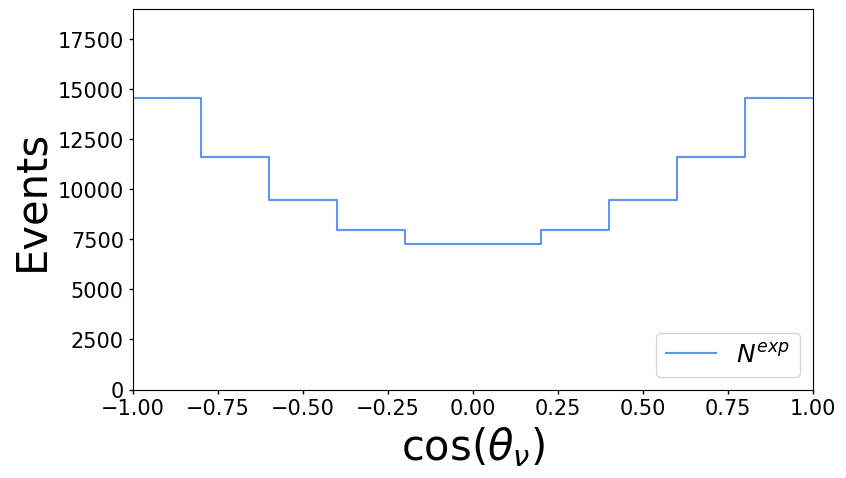

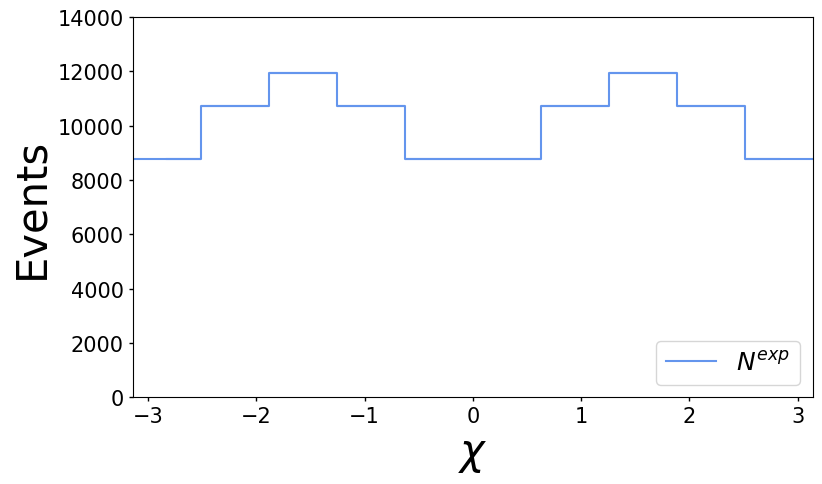

In [3]:
# Plot
# Define the parameters of the system
result_1em=[1.166, 1.184, 0.848, 0.03648]

# Calculate expected number of events
I_dist = integral_list_distributions()
I_40 = integral_list_bins()
Nexp = N_exp_e(result_1em, I_dist, I_40)

print("parameter:",result_1em)

def generate_X_values(xlims):
    """
    Generate X values based on xlims.
    
    Parameters:
    - xlims (tuple): The lower and upper limits for the X-axis.
    
    Returns:
    - X (np.array): Array of X values.
    """
    X = np.zeros(shape=(10))
    for m in range(10):
        # Calculate the midpoint values for X based on the given limits
        X[m] = m * (xlims[1] - xlims[0]) / 10. + xlims[0] + (xlims[1] - xlims[0]) / 20.
    return X

def plot_data(Y, fname, xlabel, ylabel, xlims, ylims):
    """
    Plot data and save the plot to a file.

    Parameters:
    - Y (list or np.array): The Y values to be plotted.
    - fname (str): The filename to save the plot as.
    - xlabel (str): The label for the X-axis.
    - ylabel (str): The label for the Y-axis.
    - xlims (tuple): The lower and upper limits for the X-axis.
    - ylims (tuple): The lower and upper limits for the Y-axis.
    """
    # Check if the input data has the expected length
    if len(Y) != 10:
        print(f"Error: Expected Y to have a length of 10, but got {len(Y)} instead.")
        return

    # Check if the provided limits are valid
    if xlims[0] >= xlims[1] or ylims[0] >= ylims[1]:
        print("Error: Invalid limits provided.")
        return
    
    # Generate X values
    X = generate_X_values(xlims)
    
    # Define errorbars
    lower_error = [(xlims[1]-xlims[0])/20.,]*10
    upper_error = [(xlims[1]-xlims[0])/20.,]*10
    asymmetric_error = [lower_error, upper_error] #actually symmetric
    
    # Initialize the figure
    figure = plt.gcf()
    figure.set_size_inches(8.5, 4.875)
    
    # Plot the data using step and errorbar for extending lines
    plt.step(X, Y, where='mid', label=r'$N^{exp}$', color='cornflowerblue')
    # Using errorbar as a trick to extend the lines of plt.step to the edges of the x-values
    plt.errorbar(X, Y, xerr=asymmetric_error, fmt='none', color='cornflowerblue')
    
    # Set plot aesthetics
    plt.tick_params(labelsize=15, width=1, length=3)
    plt.ylim(ylims)
    plt.xlim(xlims)
    plt.xlabel(xlabel, fontsize=30)
    plt.ylabel(ylabel, fontsize=30)
    
    # Add legend
    legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large', facecolor='white', prop={'size': 18})
    plt.subplots_adjust(left=0.15, right=.95, bottom=0.17, top=0.95)
    
    # Save the figure with error handling
    try:
        plt.savefig(fname, dpi=300, facecolor='w', edgecolor='w',
                    orientation='portrait', format=None, 
                    transparent=False, bbox_inches=None, pad_inches=0.1)
    except Exception as e:
        print(f"Error saving the file: {e}")
    
    # Display the plot
    plt.show()
    
# Plot and save the data for different parameters
plot_data(Nexp[0:10], "CLN_em1.png", 'w', "Events", [1., 1.5], [0., 13000.])
plot_data(Nexp[10:20], "CLN_em2.png", r'cos($\theta_l$)', "Events", [-1., 1.], [0., 15000.])
plot_data(Nexp[20:30], "CLN_em3.png", r'cos($\theta_{\nu}$)', "Events", [-1., 1.], [0., 19000.])
plot_data(Nexp[30:40], "CLN_em4.png", r'$\chi$', "Events", [-np.pi, np.pi], [0., 14000.])


